In [18]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [19]:
import numpy as np

In [20]:
data_batches = []
labels_batches = []

for i in range(1, 6):
    batch = unpickle(f"data/cifar-10-batches-py/data_batch_{i}")
    data_batches.append(batch[b'data'])
    labels_batches.append(batch[b'labels'])

In [21]:
images_train = np.concatenate(data_batches) 
y_train = np.concatenate(labels_batches)

test_batch = unpickle("data/cifar-10-batches-py/test_batch")
images_test = test_batch[b'data']
y_test = test_batch[b'labels']

In [22]:
import numpy as np
from skimage.feature import hog  # import hog function

def extract_hog_features(data):
    hog_features = []

    for img in data:
        # Reshape the image
        img_reshaped = np.reshape(img, (32, 32, 3))

        # Initialize a list to store the hog features of each channel
        hog_features_img = []

        for channel in range(img_reshaped.shape[2]):
            # Extract HOG features from the current channel
            feature = hog(img_reshaped[:, :, channel], orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2))

            # Append the HOG features of the current channel to hog_features_img
            hog_features_img.append(feature)

        # Concatenate the HOG features of each channel and append them to hog_features
        hog_features.append(np.concatenate(hog_features_img))

    return np.array(hog_features)

X_train = extract_hog_features(images_train)
X_test = extract_hog_features(images_test)

In [23]:
X_train

array([[0.22531424, 0.22052946, 0.24048989, ..., 0.1690073 , 0.11528662,
        0.06274257],
       [0.17634939, 0.03514505, 0.12870185, ..., 0.14132616, 0.15223541,
        0.14205324],
       [0.18963947, 0.08224693, 0.10763309, ..., 0.18289543, 0.06552798,
        0.07313401],
       ...,
       [0.1208321 , 0.06599637, 0.17650586, ..., 0.15695284, 0.21186621,
        0.09085094],
       [0.07854486, 0.03681067, 0.04463323, ..., 0.23386392, 0.04956536,
        0.03556166],
       [0.1030955 , 0.1332041 , 0.1080691 , ..., 0.16539618, 0.08178326,
        0.19017165]])

# Régression logistique

## Grid search

In [24]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import accuracy_score

# model = LogisticRegression(max_iter=20000)

# param_grid = {
#     'C': [0.01, 0.1, 1],
# }

# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)

# grid_search.fit(X_train, y_train)

# print("Best parameters: ", grid_search.best_params_)

# y_pred = grid_search.predict(X_test)

# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy: ", accuracy)

### Best parameters:  {'C': 0.1}


In [25]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

model.fit(X_train, y_train)

print("Train accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))

/home/kephas/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train accuracy: 0.39234
Test accuracy: 0.3678


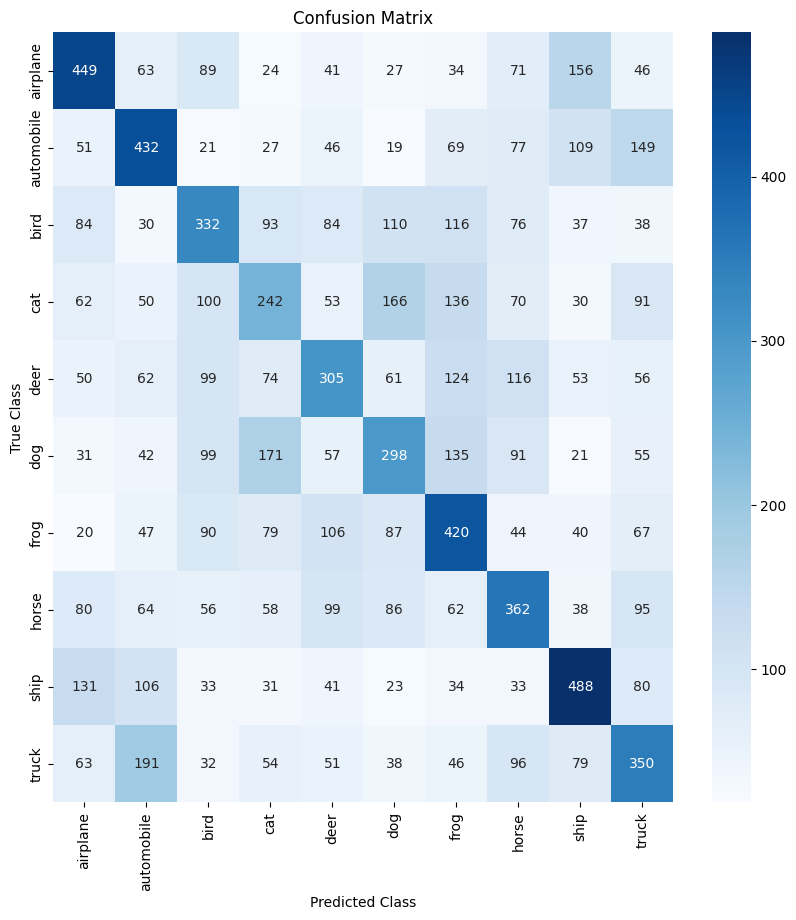

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

y_pred = model.predict(X_test)

# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Visualiser la matrice de confusion
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

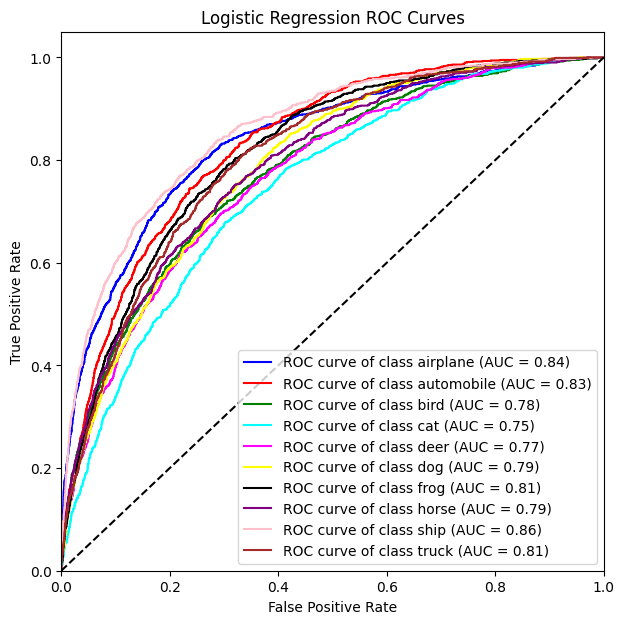

In [27]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binariser les labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
y_pred_bin = model.predict_proba(X_test)

# Initialiser le style du cycle
colors = cycle(['blue', 'red', 'green', 'cyan', 'magenta', 'yellow', 'black', 'purple', 'pink', 'brown'])

plt.figure(figsize=(7, 7))

for i, color in zip(range(len(class_names)), colors):
    # Calculer la courbe ROC pour la i-ème classe
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])

    # Calculer l'aire sous la courbe ROC (AUC)
    roc_auc = auc(fpr, tpr)

    # Tracer la courbe ROC
    plt.plot(fpr, tpr, color=color, label=f'ROC curve of class {class_names[i]} (AUC = {roc_auc:.2f})')

# Tracer la ligne de hasard
plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curves')
plt.legend(loc="lower right")
plt.show()

# SGD Classifier

## Grid search

In [28]:
# from sklearn.linear_model import SGDClassifier
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import accuracy_score

# # Définir le modèle
# model = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)

# # Définir la grille de paramètres pour la recherche sur grille
# param_grid = {
#     'loss': ['hinge', 'log'],
#     'alpha': [0.001, 0.01, 0.1, 1],
# }

# # Initialiser la recherche sur grille
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)

# # Ajuster le modèle aux données
# grid_search.fit(X_train, y_train)

# # Imprimer les meilleurs paramètres
# print("Best parameters: ", grid_search.best_params_)

# # Utiliser le meilleur modèle pour faire des prédictions
# y_pred = grid_search.predict(X_test)

# # Calculer la précision
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy: ", accuracy)

### Best parameters:  {'alpha': 0.001, 'loss': 'log'}


In [29]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

model = SGDClassifier(loss='log', alpha=0.001, # 'hinge' pour un SVM linéaire, 'log' pour la régression logistique
                      max_iter=1000, tol=1e-3, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

/home/kephas/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy: 0.3555


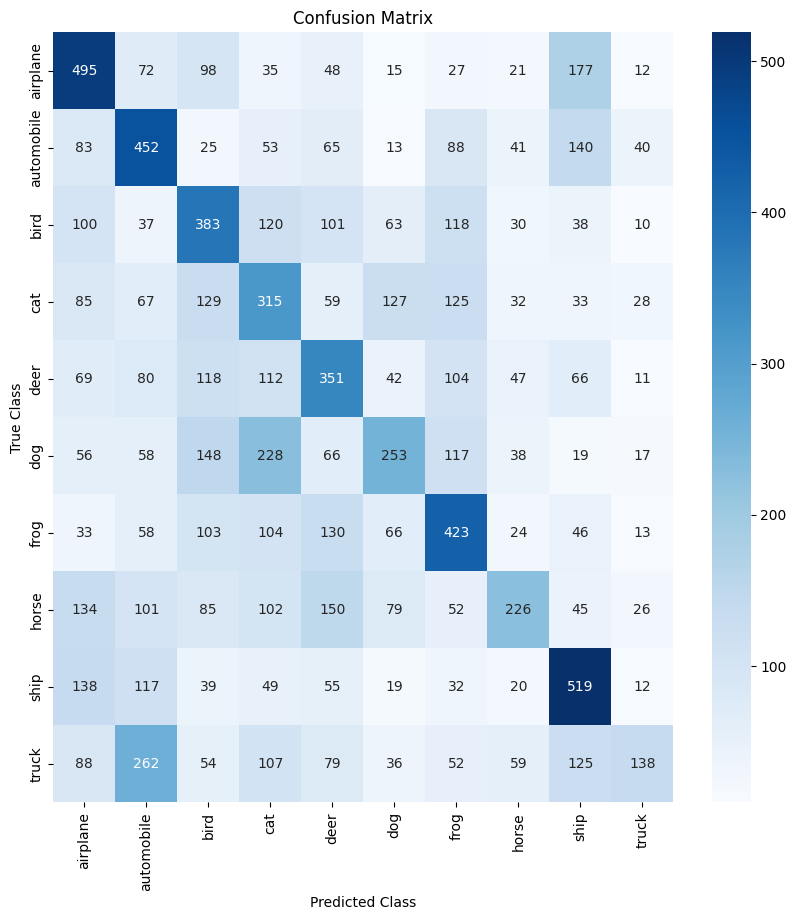

In [30]:
y_pred = model.predict(X_test)

# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Visualiser la matrice de confusion
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

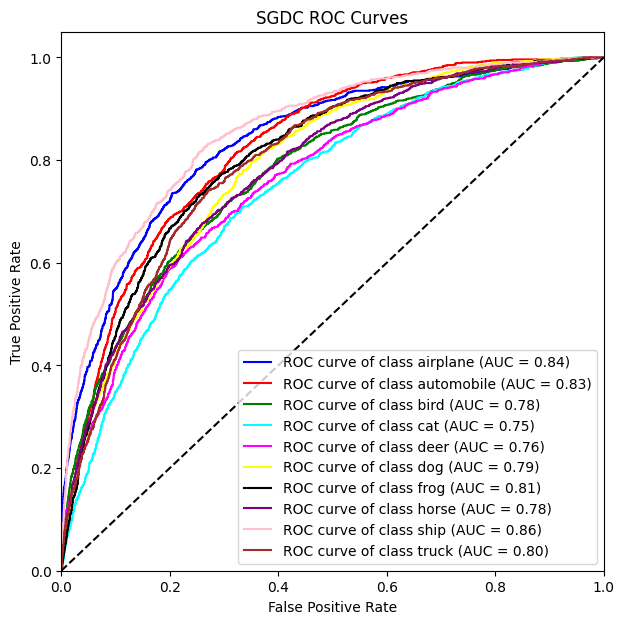

In [31]:
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
y_pred_bin = model.predict_proba(X_test)


plt.figure(figsize=(7, 7))

for i, color in zip(range(len(class_names)), colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, label=f'ROC curve of class {class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SGDC ROC Curves')
plt.legend(loc="lower right")
plt.show()

# Random Forest

## Grid search

In [32]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import accuracy_score

# clf = RandomForestClassifier()

# param_grid = {
#     'n_estimators': [50, 100],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [5, 10],
#     'min_samples_leaf': [1, 2, 4],
# }

# grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3, n_jobs=-1)

# grid_search.fit(X_train, y_train)

# print("Best parameters: ", grid_search.best_params_)

# y_pred = grid_search.predict(X_test)

# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy: ", accuracy)


### Best parameters:  {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}


In [33]:
from sklearn.ensemble import RandomForestClassifier

randomForestModel = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_split= 10,min_samples_leaf=2, random_state=42)

randomForestModel.fit(X_train, y_train)

y_pred = randomForestModel.predict(X_test)

accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.3142


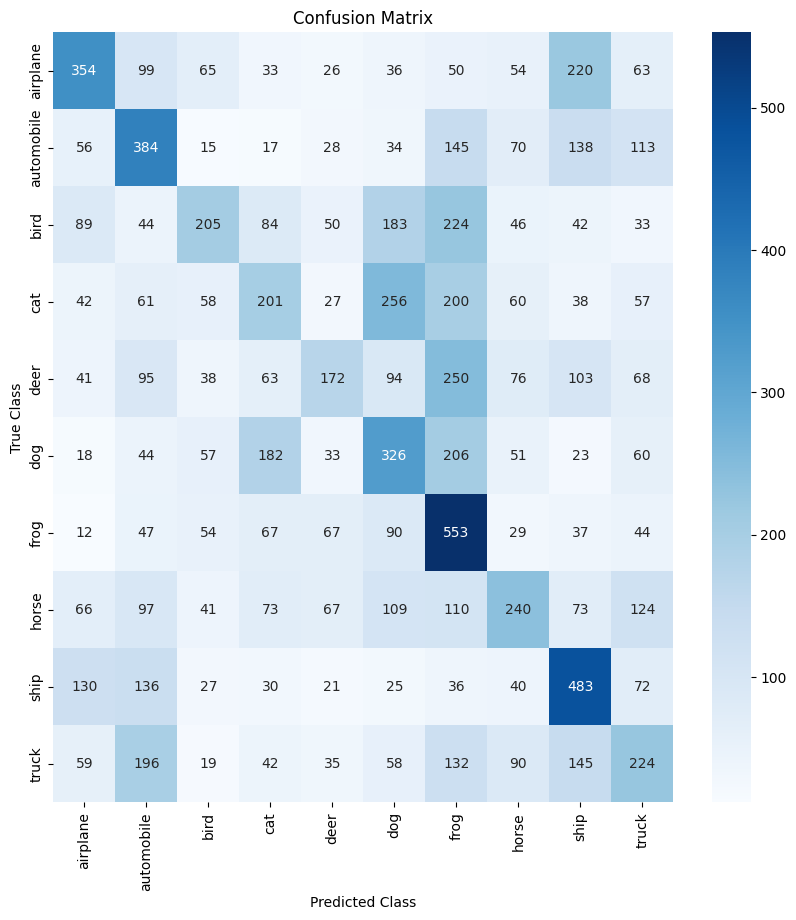

In [34]:
y_pred = randomForestModel.predict(X_test)

# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Visualiser la matrice de confusion
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

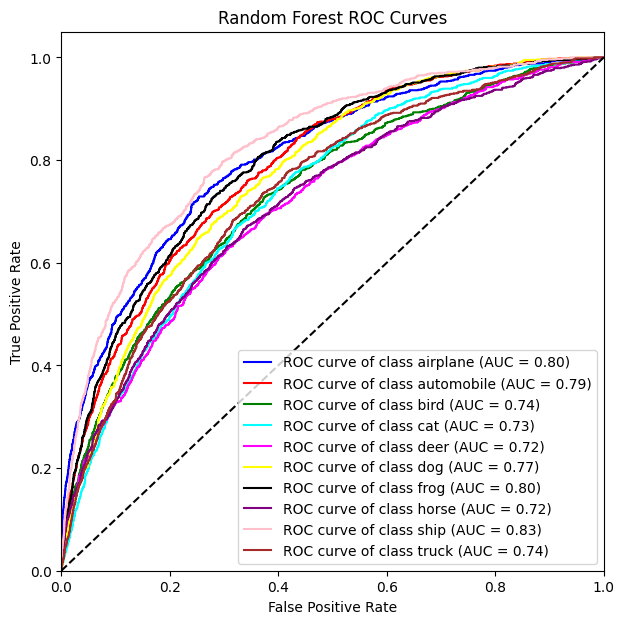

In [35]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binariser les labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
y_pred_bin = randomForestModel.predict_proba(X_test)


plt.figure(figsize=(7, 7))

for i, color in zip(range(len(class_names)), colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, label=f'ROC curve of class {class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curves')
plt.legend(loc="lower right")
plt.show()